# Домашнее задание: линейная классификация

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Сперва загрузим датасет в Python

In [150]:
data = pd.read_csv('Social_Network_Ads.csv')
data.sample(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
306,15603942,Female,51,134000,0
248,15730688,Male,41,52000,0
31,15729054,Female,27,137000,1
93,15699284,Female,29,28000,0
208,15800890,Female,40,142000,1


Данный набор данных, содержит информацию о том, покупает ли продукт человек определенного возраста, пола и с определенным доходом или нет.
Нам нужно предсказать, купит ли продукт целевая аудитория или нет.

## Предварительный анализ данных

Очевиндо, что столбец, который соответствует ID пользователя не несет для нас никакой ценной информации. Следовательно, чтобы модель не путалась из-за этого столбца, его следует удалить

In [151]:
data = data.drop('User ID', axis=1)

Посмотрим, есть ли пропущенные значения в датасете

In [152]:
data.isnull().sum()

Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           400 non-null    object
 1   Age              400 non-null    int64 
 2   EstimatedSalary  400 non-null    int64 
 3   Purchased        400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


> Какие выводы можно сделать о пропущенных значениях? Нужно ли заполнять пропущенные значения? Если нужно, то как? 

нет пропусков

Рассмотрим таблицу описательных статистик для датасета

In [154]:
data.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


> Какие средние значения для каждого признака? Какие среднеквадратичные отклонения? Какие максимальные и минимальные значения?

std: 10.48, 34096.96, 0.479;  
min: 18, 15000, 0.0;   
max: 60, 150000, 1;

Исследуем набор данных на выбросы с помощью графика
> Какой график отображает медиану, квартили и выбросы? Приведите команду для построения этого графика

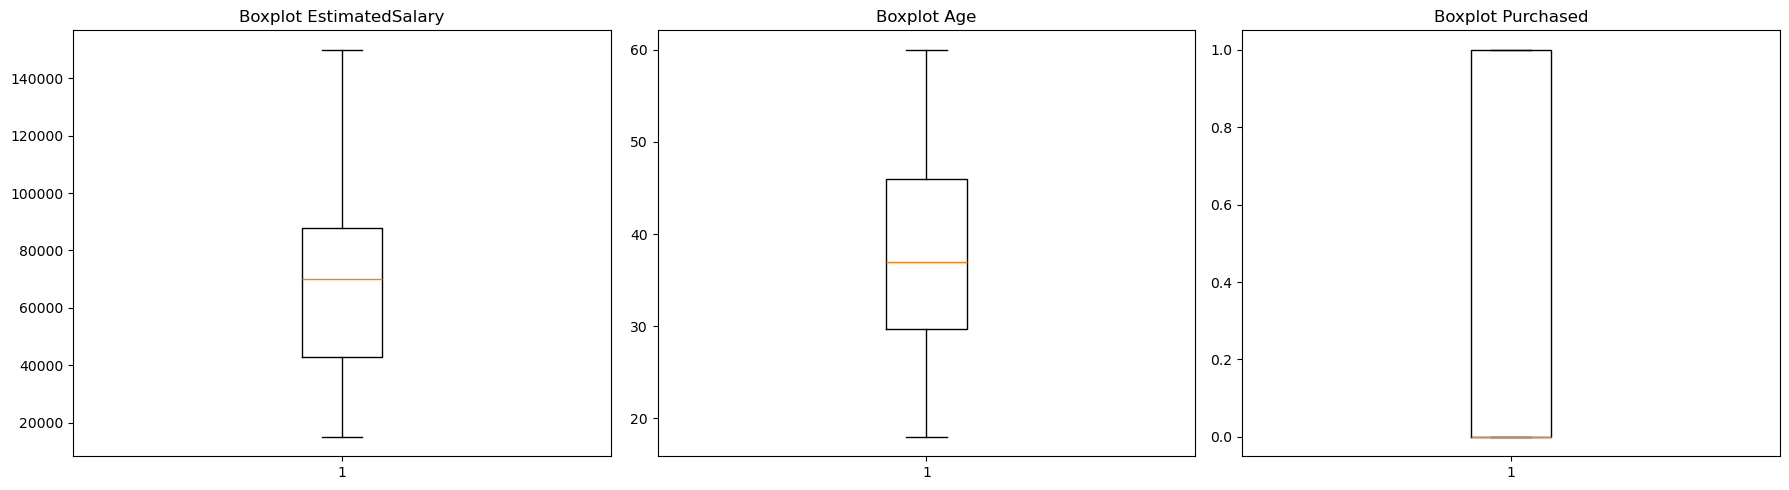

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].boxplot(data['EstimatedSalary'])
axes[0].set_title('Boxplot EstimatedSalary')

axes[1].boxplot(data['Age'])
axes[1].set_title('Boxplot Age')

axes[2].boxplot(data['Purchased'])
axes[2].set_title('Boxplot Purchased')
plt.tight_layout() 
plt.show()

> Какие выводы о наличии аномальных значений можно сделать? Будут ли они сильно влиять на прогнозы модели?

Рассмотрим гистограммы распределений данных

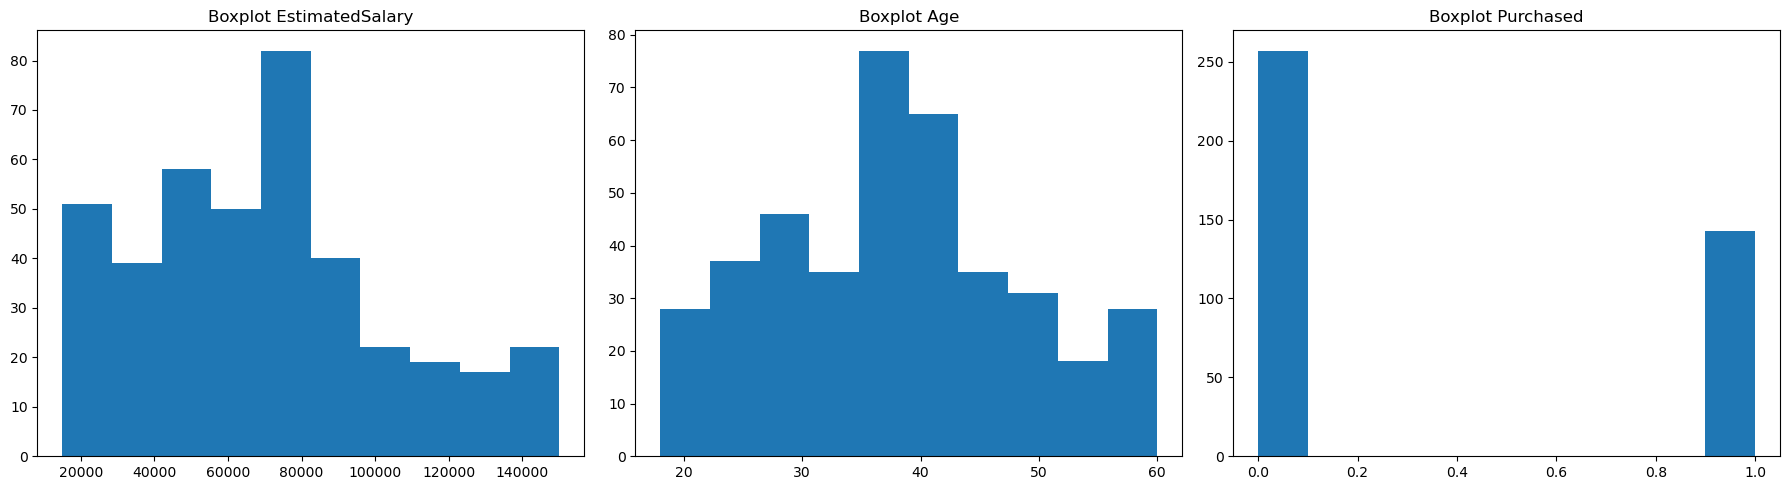

In [156]:
# YOUR CODE
# Hint: лучше выводить по отдельности
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(data['EstimatedSalary'])
axes[0].set_title('Boxplot EstimatedSalary')

axes[1].hist(data['Age'])
axes[1].set_title('Boxplot Age')

axes[2].hist(data['Purchased'])
axes[2].set_title('Boxplot Purchased')
plt.tight_layout() 
plt.show()

> Какие выводы можно сделать о распределении `Age`? Схоже ли оно с нормальным распределением?

> Какие выводы можно сделать о распределении `EsimatedSalary`? Схоже ли оно с нормальным распределением?

> Какие выводы можно сделать о распределении `Purchased`? Как называется распределение, которому подчиняется эта случайная величина?

Boxplot близок к нормальному распределению. EsimatedSalary далек от нормально распределения, смещен влево. Purchased делится на два класса: 1, 0; присутствует дисбаланс классов.

Сделаем еще некоторые предварительные выводы о взаимосвязи целевой переменной `Purchased` с остальными. Например, рассмотрим взаимосвязь `Gender` и `Age` с `Purchased`

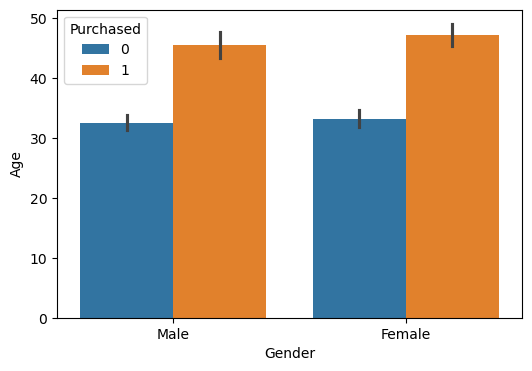

In [157]:
plt.figure(figsize=(6, 4))
sns.barplot(data=data, x='Gender', y='Age', hue='Purchased')

plt.show()

> Есть ли некоторая статистическая взаимосвязь между возрастом покупателя и совершением покупки?

> Есть ли статистическая разница между группами при совершении покупки?

люди постарше чаще покупают товар, чем молодые

Аналогично разделим на две группы по `Gender` и рассмотрим связь между `EstimatedSalary` и `Purchased`

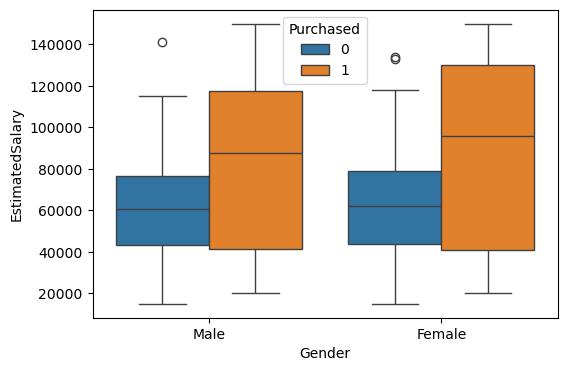

In [158]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=data, x='Gender', y='EstimatedSalary', hue='Purchased')

plt.show()

> Есть ли некоторая статистическая взаимосвязь между запрлатой покупателя и совершением покупки?

> Есть ли статистическая разница между группами при совершении покупки?

> Подумайте является ли `Gender` значимым фактором или мы можем удалить его?

Товар покупаю более состоятельные как мужчины, так и женщины

Можно удалить гендер, так как мужчины и женщины одинаково покупают/не покупают товар в зависимости от достатка

Из графиков заметно, что ответ на последний вопрос <<не является>>. Следовательно, этот признак можно исключить из модели

In [159]:
data = data.drop('Gender', axis = 1)

В итоге для моделирования у нас остались два значимых признака: `Age` и `EstimatedSalary`. Обозначим признаки за $X$, а целевую переменную за $y$

In [160]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

Приняв каждый из признаков за координаты точек в признаковом пространстве, построим график рассеяния с метками классов

In [161]:
print(X.shape)

(400, 2)


In [162]:
print(y.shape)

(400,)


In [163]:
X

array([[    19,  19000],
       [    35,  20000],
       [    26,  43000],
       [    27,  57000],
       [    19,  76000],
       [    27,  58000],
       [    27,  84000],
       [    32, 150000],
       [    25,  33000],
       [    35,  65000],
       [    26,  80000],
       [    26,  52000],
       [    20,  86000],
       [    32,  18000],
       [    18,  82000],
       [    29,  80000],
       [    47,  25000],
       [    45,  26000],
       [    46,  28000],
       [    48,  29000],
       [    45,  22000],
       [    47,  49000],
       [    48,  41000],
       [    45,  22000],
       [    46,  23000],
       [    47,  20000],
       [    49,  28000],
       [    47,  30000],
       [    29,  43000],
       [    31,  18000],
       [    31,  74000],
       [    27, 137000],
       [    21,  16000],
       [    28,  44000],
       [    27,  90000],
       [    35,  27000],
       [    33,  28000],
       [    30,  49000],
       [    26,  72000],
       [    27,  31000],


In [164]:
y

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

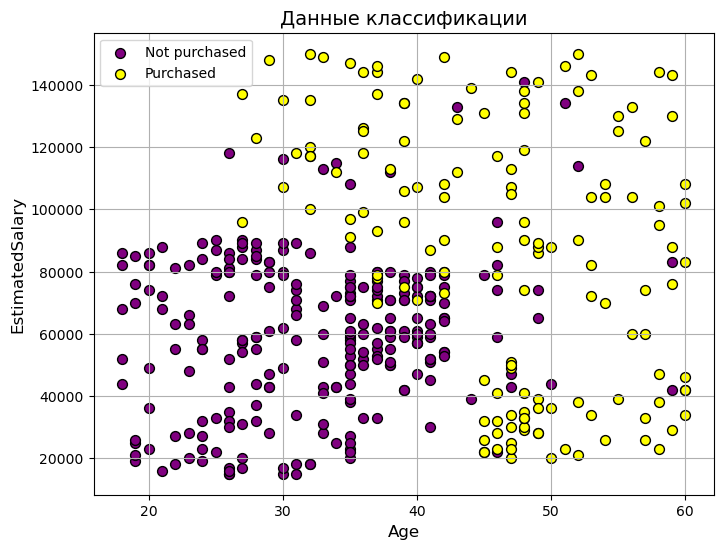

In [165]:
plt.figure(figsize=(8, 6))
assert len(X) == len(y)
scatter = plt.scatter(
    X[y == 0][:, 0], X[y ==0][:, 1], c='purple', edgecolor='k', s=50, label='Not purchased', 
)

scatter = plt.scatter(
    X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Purchased',    
)

plt.title("Данные классификации", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("EstimatedSalary", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Как видно, некоторая четко разделимая взаимосвязь есть.

> Попробуйте объяснить с физической точки зрения, какая взаимосвязь. Как возраст и зарплата в совокупности влияют на совершение покупки

Богатые люди покупают товар раньше, а в преклонном возрасте его покупают люди с меньшим уровнем дохода

В качестве последнего этапа стандартизируем нашу выборку, чтобы модели лучше отрабатывали

In [166]:
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(400, 2))

> Нужно ли стандартизировать $y$?

Для задач классификации:
y — это категории (0/1), стандартизация бессмысленна.
Для задач регрессии:
Стандартизация y не влияет на качество большинства моделей (например, линейная регрессия, Random Forest).

Снова построим диаграмму рассеяния, чтобы посмотреть, как изменился результат

In [167]:
y.shape

(400,)

In [168]:
X.shape

(400, 2)

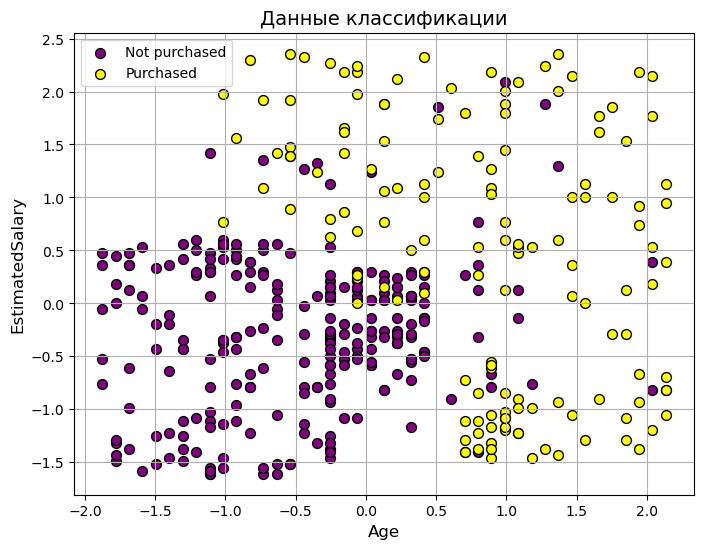

In [169]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X[y == 0][:, 0], X[y ==0][:, 1], c='purple', edgecolor='k', s=50, label='Not purchased', 
)

scatter = plt.scatter(
    X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Purchased',    
)

plt.title("Данные классификации", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("EstimatedSalary", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

> Что изменилось по сравнению с предыдущим случаем?

среднее значение = 0, стандартное отклонение = 1

## Построение классификационных моделей

### Логистическая регрессия

Разделим всю выборку на train и test наборы

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Теперь воспользуемся уже готовой реализацией модели линейной регрессии из библиотеки sklearn

In [171]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()

Обучим модель на train выборке

In [172]:
model1.fit(X_train, y_train)

LogisticRegression()

Определим функцию для визуализации разделяющей гиперплоскости

In [173]:
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.title("Classification result")
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.show()

Построим разделяющую гиперплоскость на всей выборке

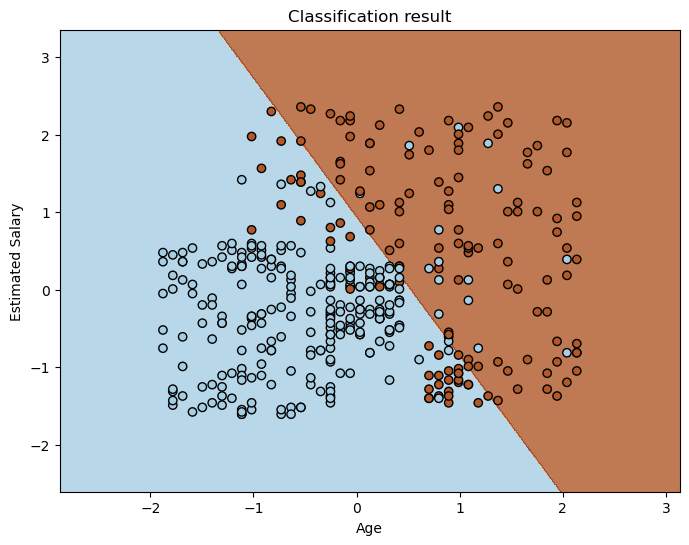

In [174]:
plot_decision_boundary(X, y, model1)

> Какие можно сделать выводы о качестве классификации из визуального представления?

модель достаточно точно определила закономерность, но если ошибки, так как линейным алгоритмом зависимость не описать до конца

Определим метрики классификации

In [175]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

И зададим функцию, которая сразу будет возвращать все метрики классификации

In [176]:
def show_metrics(target, predicts):
    confusion = confusion_matrix(target, predicts)
    accuracy = accuracy_score(target, predicts)
    precision = precision_score(target, predicts)
    recall = recall_score(target, predicts)

    print('=====================================')
    print(f'Confusion matrix : \n{confusion}')
    print('=====================================')
    print(f'Accuracy : {accuracy}')
    print('=====================================')
    print(f'Recall_Score : {recall}')
    print('=====================================')
    print(f'Precision Score : {precision}')

Вычислим значения метрик классификации на обучающей и тестовой выборках

In [177]:
y_hat = model1.predict(X_train)

show_metrics(y_train, y_hat)

Confusion matrix : 
[[190  15]
 [ 36  79]]
Accuracy : 0.840625
Recall_Score : 0.6869565217391305
Precision Score : 0.8404255319148937


In [178]:
y_pred = model1.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[50  2]
 [ 9 19]]
Accuracy : 0.8625
Recall_Score : 0.6785714285714286
Precision Score : 0.9047619047619048


> Какие выводы можно сделать о результате классификации?

классифицировано не супер хорошо, но на тесте результат лучше

### Метод опорных векторов (линейный)

Проделяем все аналогичные действия для модели опорных векторов

In [179]:
from sklearn.svm import LinearSVC

model2 = LinearSVC()

Обучим модель на train выборке

In [180]:
model2.fit(X_train, y_train)

LinearSVC()

Построим разделяющую гиперплоскость на всей выборке

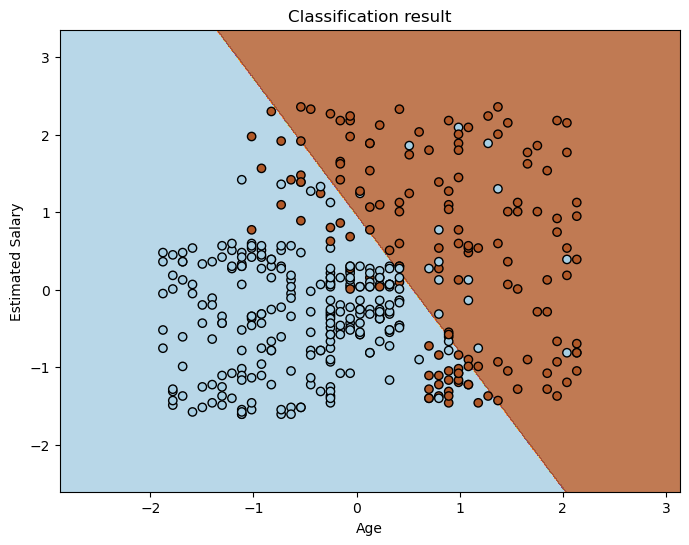

In [181]:
plot_decision_boundary(X, y, model2)

> Какие можно сделать выводы о качестве классификации из визуального представления? Есть ли кардинальные отличия по сравнению с логистической моделью?

вообще нет отличий

Вычислим значения метрик классификации на обучающей и тестовой выборках

In [182]:
y_hat = model2.predict(X_train)

show_metrics(y_train, y_hat)

Confusion matrix : 
[[190  15]
 [ 37  78]]
Accuracy : 0.8375
Recall_Score : 0.6782608695652174
Precision Score : 0.8387096774193549


In [183]:
y_pred = model2.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[50  2]
 [ 9 19]]
Accuracy : 0.8625
Recall_Score : 0.6785714285714286
Precision Score : 0.9047619047619048


> Какие выводы можно сделать о результате классификации? Стали ли метрики лучше по сравнению с логистической моделью или наоборот ухудшились?

остались примерно такими же

### Метод опорных векторов (с ядром)

Здесь мы воспользуемся уже [готовой реализацией из sklearn](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py)

In [184]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

def plot_training_data_with_decision_boundary(
    clf, X, y, ax=None, support_vectors=True,
):

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 8))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=150,
            facecolors="none",
            edgecolors="k",
        )

    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f" Decision boundaries of SVC")

    if ax is None:
        plt.show()

Далее обучим модель с линейным ядром (то же самое, что и в предыдущем случае)

c:\Users\Asus\anaconda3\envs\mykerenv\lib\site-packages\matplotlib\collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


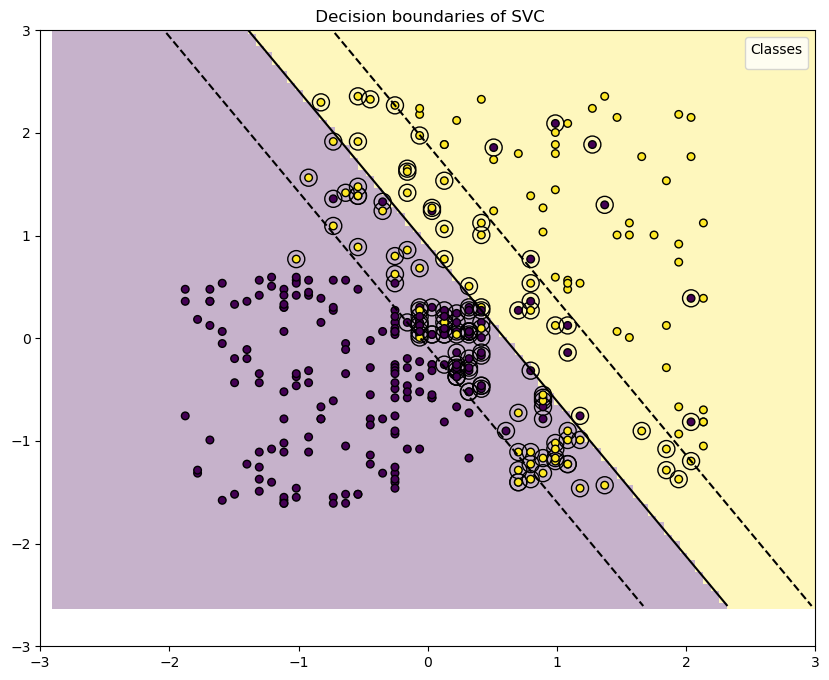

In [185]:
clf = svm.SVC(kernel='linear').fit(X_train, y_train)

plot_training_data_with_decision_boundary(clf, X_train, y_train)

Еще раз рассмотрим метрики на тестовом наборе, чтобы убедиться в том, что прошлый классификатор действительно имеет линейное ядро

In [186]:
y_pred = clf.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[50  2]
 [ 9 19]]
Accuracy : 0.8625
Recall_Score : 0.6785714285714286
Precision Score : 0.9047619047619048


Теперь построим классификатор с полиномиальным ядром.

Из документации SVC:
- `degreeint, default=3`

Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

Под этим понимается, что по стандарту модель использует полиномиальное ядро третьей степени

c:\Users\Asus\anaconda3\envs\mykerenv\lib\site-packages\matplotlib\collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


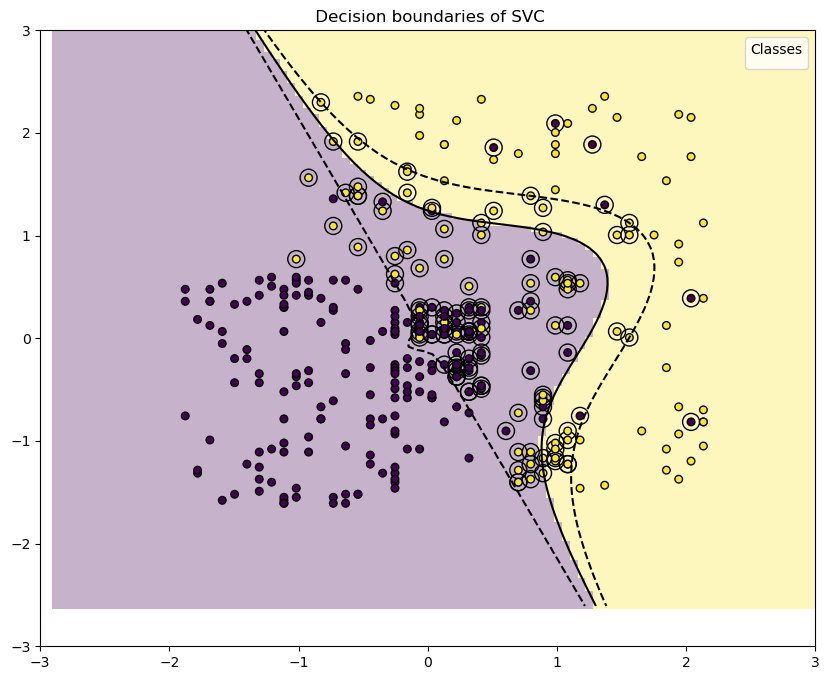

In [187]:
clf = svm.SVC(kernel='poly').fit(X_train, y_train)

plot_training_data_with_decision_boundary(clf, X_train, y_train)

Рассмотирм метрики на тестовом наборе

In [188]:
y_pred = clf.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[52  0]
 [ 9 19]]
Accuracy : 0.8875
Recall_Score : 0.6785714285714286
Precision Score : 1.0


> Есть ли изменения в метриках? Что стало лучше, что стало худше? Что можно в целом сказать о модели: стала ли она качественнее классифицировать данные?

модель стала качественнее классифицировать

Теперь построим модель с использованием гауссовского ядра

c:\Users\Asus\anaconda3\envs\mykerenv\lib\site-packages\matplotlib\collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


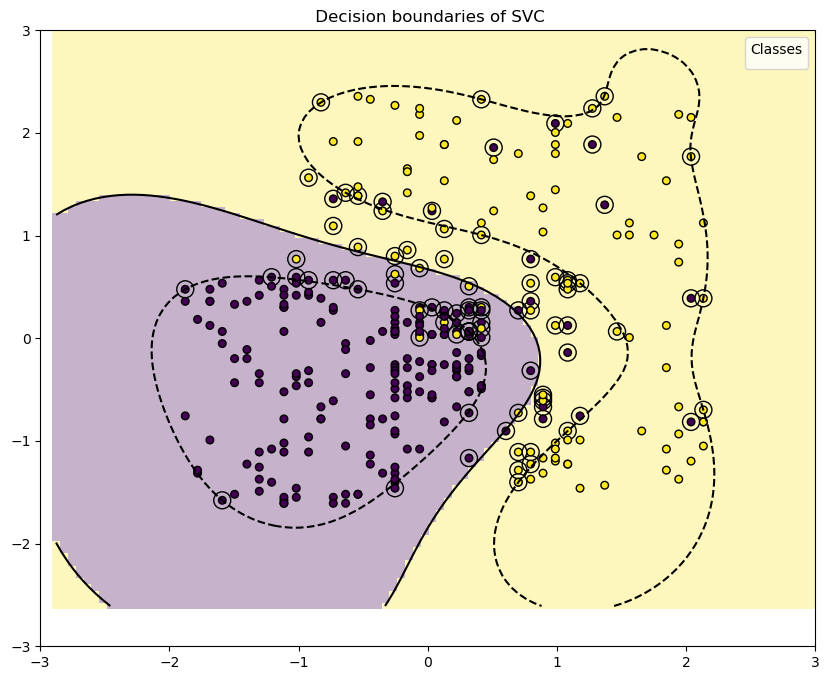

In [189]:
clf = svm.SVC(kernel='rbf').fit(X_train, y_train)

plot_training_data_with_decision_boundary(clf, X_train, y_train)

In [190]:
y_hat = clf.predict(X_train)

show_metrics(y_train, y_hat)

Confusion matrix : 
[[186  19]
 [ 11 104]]
Accuracy : 0.90625
Recall_Score : 0.9043478260869565
Precision Score : 0.8455284552845529


Рассмотирм метрики на тестовом наборе

In [191]:
y_pred = clf.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[47  5]
 [ 1 27]]
Accuracy : 0.925
Recall_Score : 0.9642857142857143
Precision Score : 0.84375


> Есть ли изменения в метриках? Что стало лучше, что стало худше? Что можно в целом сказать о модели: стала ли она качественнее классифицировать данные?

> Проведите сравнительный анализ всех моделей между собой 

метрики стали лучше по сравнению со всеми предыдущими моделями

## Выводы

Таким образом, лучшей моделью (по вашему мнению) для решения задачи классификации покупательского спроса является модель -- с использованием Гаусовского ряда.

Она имеет следующие метрики:
- На Обучающем наборе
- - Accuracy : 0.906
  - Precision : 0.845 
  - Recall : 0.904
- На Тестовом наборе
- - Accuracy : 0.925
  - Precision : 0.84375
  - Recall : 0.96428

Стоит понимать, что это не столько эталонный анализ, сколько базовый минимум. Вспомним, что в моделях также присутствуют гиперпараметры (например, регуляризация). По стандарту в моделях стоит значение $\lambda = 1$ для $L_2$ регуляризационного слагаемого. С помощью кросс-валидации по сетке можно было бы подобрать такой гиперпараметр, при котором результат классификации был бы лучше.

> По желанию можете попробовать реализовать кросс-валидацию по сетке значений гиперпараметра для логистической регрессии и линейной SVM. Попробуйте сравнить результаты

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [193]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid = {
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty' : ['l1', 'l2'],
    'model__solver' : ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [194]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [195]:
y_pred = grid_search.predict(X_test)

show_metrics(y_test, y_pred)

Confusion matrix : 
[[50  2]
 [ 7 21]]
Accuracy : 0.8875
Recall_Score : 0.75
Precision Score : 0.9130434782608695


In [196]:
print("Лучшие параметры: ", grid_search.best_estimator_)
print("Лучшая точность: ", grid_search.best_score_)

Лучшие параметры:  Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])
Лучшая точность:  0.83125


In [ ]:
from sklearn.svm import LinearSVC

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearSVC(max_iter=10000)) 
])

param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__loss': ['hinge', 'squared_hinge']
}

grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

Лучшие параметры: {'model__C': 0.01, 'model__loss': 'hinge', 'model__penalty': 'l2'}
Лучшая точность: 0.825
